In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.abs import UnaryAbs
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
rng = "Sobol"

in_dim = 1024

mode = "bipolar"
bitwidth = 8
buf_dep = 8
sr = False
bstype = torch.float
buftype = torch.float
randtype = torch.float

uAbs = UnaryAbs(buf_dep=buf_dep, bitwidth=bitwidth, shiftreg=sr, bstype=bstype, buftype=buftype).to(device)

iVec = (((torch.rand(in_dim)*2-1)*(2**bitwidth)).round()/(2**bitwidth)).to(device)
# iVec = torch.tensor([0.039]).to(device)
start_time = time.time()
oVec = torch.abs(iVec)
print("--- %s seconds ---" % (((time.time() - start_time))*2**bitwidth))

print("input", iVec)
print("real output", oVec)
        
iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode, randtype=randtype)().to(device)

iVecRNG = RNG(bitwidth, 1, rng, randtype)().to(device)
iVecBS = BSGen(iVecSource, iVecRNG, bstype).to(device)

iVecPE = ProgressiveError(iVec, mode=mode).to(device)
oVecPE = ProgressiveError(oVec, mode=mode).to(device)

with torch.no_grad():
    idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
    start_time = time.time()
    for i in range((2**bitwidth)):
        iBS = iVecBS(idx + i)
        iVecPE.Monitor(iBS)

        oVecU = uAbs(iBS)
        oVecPE.Monitor(oVecU)

    print("--- %s seconds ---" % (time.time() - start_time))
    print("final input error: ", min(iVecPE()[1]), max(iVecPE()[1]))
    print("final output error:", min(oVecPE()[1]), max(oVecPE()[1]))
    print("final output pp:", oVecPE()[0].data)
    print("final output pe:", oVecPE()[1].data)
    print("final output mean error:", oVecPE()[1].mean())
    
    result_pe = oVecPE()[1].cpu().numpy()

--- 0.0 seconds ---
input tensor([ 0.0781,  0.8086, -0.3945,  ...,  0.3008, -0.4727,  0.2852],
       device='cuda:0')
real output tensor([0.0781, 0.8086, 0.3945,  ..., 0.3008, 0.4727, 0.2852], device='cuda:0')
--- 0.23100662231445312 seconds ---
final input error:  tensor(-0.0078, device='cuda:0') tensor(0.0039, device='cuda:0')
final output error: tensor(-0.5039, device='cuda:0') tensor(0.0039, device='cuda:0')
final output pp: tensor([0.0781, 0.8125, 0.3828,  ..., 0.2969, 0.4609, 0.2812], device='cuda:0')
final output pe: tensor([ 0.0000,  0.0039, -0.0117,  ..., -0.0039, -0.0117, -0.0039],
       device='cuda:0')
final output mean error: tensor(-0.0112, device='cuda:0')


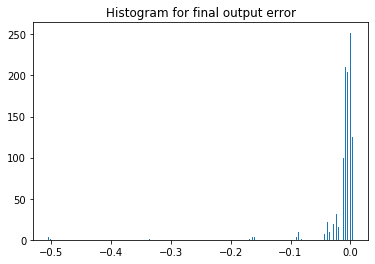

In [5]:
fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for final output error")
plt.show()

In [6]:
print(result_pe)
print(result_pe.argmin(), result_pe.argmax())
print(result_pe[result_pe.argmin()], result_pe[result_pe.argmax()])
print(iVec[result_pe.argmin()], iVec[result_pe.argmax()])

[ 0.          0.00390625 -0.01171875 ... -0.00390625 -0.01171875
 -0.00390625]
70 1
-0.50390625 0.00390625
tensor(0.0039, device='cuda:0') tensor(0.8086, device='cuda:0')


In [7]:
print(uAbs.acc[result_pe.argmin()], uAbs.acc[result_pe.argmax()])

tensor(128., device='cuda:0') tensor(255., device='cuda:0')
